<i>Copyright (c) Recommenders contributors.</i>

<i>Licensed under the MIT License.</i>

# LightGCN - simplified GCN model for recommendation

This notebook serves as an introduction to LightGCN [1], which is an simple, linear and neat Graph Convolution Network (GCN) [3] model for recommendation.

In [ ]:
 !git clone https://github.com/recommenders-team/recommenders.git



Cloning into 'recommenders'...
remote: Enumerating objects: 40874, done.
remote: Counting objects: 100% (4398/4398), done.
remote: Compressing objects: 100% (1530/1530), done.
remote: Total 40874 (delta 2895), reused 3908 (delta 2649), pack-reused 36476
Receiving objects: 100% (40874/40874), 214.25 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (27538/27538), done.


In [ ]:
!pip install git+https://github.com/recommenders-team/recommenders.git


  Cloning https://github.com/recommenders-team/recommenders.git to /tmp/pip-req-build-fa_4lu94
  Running command git clone --filter=blob:none --quiet https://github.com/recommenders-team/recommenders.git /tmp/pip-req-build-fa_4lu94
  Resolved https://github.com/recommenders-team/recommenders.git to commit 310370b2a0fd3366bce264b9b007ad6d6af330e0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 22.7 MB

In [ ]:
# Create a new conda environment with Python 3.9
!pip create -n recommenders-env python=3.9 -y


# Activate the environment
!pip activate recommenders-env

# Install the recommenders library within the new environment
!pip install recommenders[all]

ERROR: unknown command "create"
ERROR: unknown command "activate"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.5/281.5 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 47.0 MB/s e

## 0 Global Settings and Imports

In [ ]:
import sys
import os
import pandas as pd
import numpy as np

import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
from recommenders.utils.timer import Timer
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Tensorflow version: {tf.__version__}")

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:47: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas version: 1.5.3
Tensorflow version: 2.8.4


In [ ]:


# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
SEED = 123  # Set None for non-deterministic results
import os
path= os.getcwd()
yaml_file = "/content/recommenders/recommenders/models/deeprec/config/lightgcn.yaml"

user_file = os.path.join(path, "tests/resources/deeprec/lightgcn/user_embeddings.csv")


item_file = os.path.join(path, "tests/resources/deeprec/lightgcn/item_embeddings.csv")

## 1 LightGCN model

LightGCN is a simplified version of Neural Graph Collaborative Filtering (NGCF) [4], which adapts GCNs in recommendation systems.

### 1.1 Graph Networks in Recommendation Systems

GCN are networks that can learn patterns in graph data. They can be applied in many fields, but they are particularly well suited for Recommendation Systems, because of their ability to encode relationships.

In traditional models like matrix factorization [5], user and items are represented as embeddings. And the interaction, which is the signal that encodes the behavior, is not part of the embeddings, but it is represented in the loss function, typically as a dot product.

Despite their effectiveness, some authors [1,4] argue that these methods are not sufficient to yield satisfactory embeddings for collaborative filtering. The key reason is that the embedding function lacks an explicit encoding of the crucial collaborative signal, which is latent in user-item interactions to reveal the behavioral similarity between users (or items).

**GCNs can be used to encode the interaction signal in the embeddings**. Interacted items can be seen as user´s features, because they provide direct evidence on a user’s preference. Similarly, the users that consume an item can be treated as the item’s features and used to measure the collaborative similarity of two items. A natural way to incorporate the interaction signal in the embedding is by exploiting the high-order connectivity from user-item interactions.

In the figure below, the user-item interaction is shown (to the left) as well as the concept of higher-order connectivity (to the right).

<img src="https://recodatasets.z20.web.core.windows.net/images/High_order_connectivity.png" width=500 style="display:block; margin-left:auto; margin-right:auto;">

The high-order connectivity shows the collaborative signal in a graph form. For example, the path $u_1 ← i_2 ← u2$ indicates the behavior
similarity between $u_1$ and $u_2$, as both users have interacted with $i_2$; the longer path $u_1 ← i_2 ← u_2 ← i_4$ suggests that $u_1$ is likely to adopt $i_4$, since her similar user $u_2$ has consumed $i_4$ before. Moreover, from the holistic view of $l = 3$, item $i_4$ is more likely to be of interest to $u_1$ than item $i_5$, since there are two paths connecting $(i_4,u_1)$, while only one path connects $(i_5,u_1)$.

Based on this high-order connectivity, NGCF [4] defines an embedding propagation layer, which refines a user’s (or an item’s) embedding by aggregating the embeddings of the interacted items (or users). By stacking multiple embedding propagation layers, we can enforce the embeddings
to capture the collaborative signal in high-order connectivities.

More formally, let $\mathbf{e}_{u}^{0}$ denote the original embedding of user $u$ and $\mathbf{e}_{i}^{0}$ denote the original embedding of item $i$. The embedding propagation can be computed recursively as:

$$
\begin{array}{l}
\mathbf{e}_{u}^{(k+1)}=\sigma\bigl( \mathbf{W}_{1}\mathbf{e}_{u}^{(k)} + \sum_{i \in \mathcal{N}_{u}} \frac{1}{\sqrt{\left|\mathcal{N}_{u}\right|} \sqrt{\left|\mathcal{N}_{i}\right|}} (\mathbf{W}_{1}\mathbf{e}_{i}^{(k)} + \mathbf{W}_{2}(\mathbf{e}_{i}^{(k)}\cdot\mathbf{e}_{u}^{(k)}) ) \bigr)
\\
\mathbf{e}_{i}^{(k+1)}=\sigma\bigl( \mathbf{W}_{1}\mathbf{e}_{i}^{(k)} +\sum_{u \in \mathcal{N}_{i}} \frac{1}{\sqrt{\left|\mathcal{N}_{i}\right|} \sqrt{\left|\mathcal{N}_{u}\right|}} (\mathbf{W}_{1}\mathbf{e}_{u}^{(k)} + \mathbf{W}_{2}(\mathbf{e}_{u}^{(k)}\cdot\mathbf{e}_{i}^{(k)}) ) \bigr)
\end{array}
$$

where $\mathbf{W}_{1}$ and $\mathbf{W}_{2}$ are trainable weight matrices, $\frac{1}{\sqrt{\left|\mathcal{N}_{i}\right|} \sqrt{\left|\mathcal{N}_{u}\right|}}$ is a discount factor expressed as the graph Laplacian norm, $\mathcal{N}_{u}$ and $\mathcal{N}_{i}$ denote the first-hop neighbors of user $u$ and item $i$, and $\sigma$ is a non-linearity that in the paper is set as a LeakyReLU.

To obtain the final representation, each propagated embedding is concatenated (i.e., $\mathbf{e}_{u}^{(*)}=\mathbf{e}_{u}^{(0)}||...||\mathbf{e}_{u}^{(l)}$), and then the final user's preference over an item is computed as a dot product: $\hat y_{u i} = \mathbf{e}_{u}^{(*)T}\mathbf{e}_{i}^{(*)}$.

### 1.2 LightGCN architecture

LightGCN is a simplified version of NGCF [4] to make it more concise and appropriate for recommendations. The model architecture is illustrated below.

<img src="https://recodatasets.z20.web.core.windows.net/images/lightGCN-model.jpg" width=600 style="display:block; margin-left:auto; margin-right:auto;">

In Light Graph Convolution, only the normalized sum of neighbor embeddings is performed towards next layer; other operations like self-connection, feature transformation via weight matrices, and nonlinear activation are all removed, which largely simplifies NGCF. In the layer combination step, instead of concatenating the embeddings, we sum over the embeddings at each layer to obtain the final representations.

### 1.3 Light Graph Convolution (LGC)

In LightGCN, we adopt the simple weighted sum aggregator and abandon the use of feature transformation and nonlinear activation. The graph convolution operation in LightGCN is defined as:

$$
\begin{array}{l}
\mathbf{e}_{u}^{(k+1)}=\sum_{i \in \mathcal{N}_{u}} \frac{1}{\sqrt{\left|\mathcal{N}_{u}\right|} \sqrt{\left|\mathcal{N}_{i}\right|}} \mathbf{e}_{i}^{(k)} \\
\mathbf{e}_{i}^{(k+1)}=\sum_{u \in \mathcal{N}_{i}} \frac{1}{\sqrt{\left|\mathcal{N}_{i}\right|} \sqrt{\left|\mathcal{N}_{u}\right|}} \mathbf{e}_{u}^{(k)}
\end{array}
$$

The symmetric normalization term $\frac{1}{\sqrt{\left|\mathcal{N}_{u}\right|} \sqrt{\left|\mathcal{N}_{i}\right|}}$ follows the design of standard GCN, which can avoid the scale of embeddings increasing with graph convolution operations.


### 1.4 Layer Combination and Model Prediction

In LightGCN, the only trainable model parameters are the embeddings at the 0-th layer, i.e., $\mathbf{e}_{u}^{(0)}$ for all users and $\mathbf{e}_{i}^{(0)}$ for all items. When they are given, the embeddings at higher layers can be computed via LGC. After $K$ layers LGC, we further combine the embeddings obtained at each layer to form the final representation of a user (an item):

$$
\mathbf{e}_{u}=\sum_{k=0}^{K} \alpha_{k} \mathbf{e}_{u}^{(k)} ; \quad \mathbf{e}_{i}=\sum_{k=0}^{K} \alpha_{k} \mathbf{e}_{i}^{(k)}
$$

where $\alpha_{k} \geq 0$ denotes the importance of the $k$-th layer embedding in constituting the final embedding. In our experiments, we set $\alpha_{k}$ uniformly as $1 / (K+1)$.

The model prediction is defined as the inner product of user and item final representations:

$$
\hat{y}_{u i}=\mathbf{e}_{u}^{T} \mathbf{e}_{i}
$$

which is used as the ranking score for recommendation generation.


### 1.5 Matrix Form

Let the user-item interaction matrix be $\mathbf{R} \in \mathbb{R}^{M \times N}$ where $M$ and $N$ denote the number of users and items, respectively, and each entry $R_{ui}$ is 1 if $u$ has interacted with item $i$ otherwise 0. We then obtain the adjacency matrix of the user-item graph as

$$
\mathbf{A}=\left(\begin{array}{cc}
\mathbf{0} & \mathbf{R} \\
\mathbf{R}^{T} & \mathbf{0}
\end{array}\right)
$$

Let the 0-th layer embedding matrix be $\mathbf{E}^{(0)} \in \mathbb{R}^{(M+N) \times T}$, where $T$ is the embedding size. Then we can obtain the matrix equivalent form of LGC as:

$$
\mathbf{E}^{(k+1)}=\left(\mathbf{D}^{-\frac{1}{2}} \mathbf{A} \mathbf{D}^{-\frac{1}{2}}\right) \mathbf{E}^{(k)}
$$

where $\mathbf{D}$ is a $(M+N) \times(M+N)$ diagonal matrix, in which each entry $D_{ii}$ denotes the number of nonzero entries in the $i$-th row vector of the adjacency matrix $\mathbf{A}$ (also named as degree matrix). Lastly, we get the final embedding matrix used for model prediction as:

$$
\begin{aligned}
\mathbf{E} &=\alpha_{0} \mathbf{E}^{(0)}+\alpha_{1} \mathbf{E}^{(1)}+\alpha_{2} \mathbf{E}^{(2)}+\ldots+\alpha_{K} \mathbf{E}^{(K)} \\
&=\alpha_{0} \mathbf{E}^{(0)}+\alpha_{1} \tilde{\mathbf{A}} \mathbf{E}^{(0)}+\alpha_{2} \tilde{\mathbf{A}}^{2} \mathbf{E}^{(0)}+\ldots+\alpha_{K} \tilde{\mathbf{A}}^{K} \mathbf{E}^{(0)}
\end{aligned}
$$

where $\tilde{\mathbf{A}}=\mathbf{D}^{-\frac{1}{2}} \mathbf{A} \mathbf{D}^{-\frac{1}{2}}$ is the symmetrically normalized matrix.

### 1.6 Model Training

We employ the Bayesian Personalized Ranking (BPR) loss which is a pairwise loss that encourages the prediction of an observed entry to be higher than its unobserved counterparts:

$$
L_{B P R}=-\sum_{u=1}^{M} \sum_{i \in \mathcal{N}_{u}} \sum_{j \notin \mathcal{N}_{u}} \ln \sigma\left(\hat{y}_{u i}-\hat{y}_{u j}\right)+\lambda\left\|\mathbf{E}^{(0)}\right\|^{2}
$$

Where $\lambda$ controls the $L_2$ regularization strength. We employ the Adam optimizer and use it in a mini-batch manner.


## 2 TensorFlow implementation of LightGCN with MovieLens dataset

We will use the MovieLens dataset, which is composed of integer ratings from 1 to 5.

We convert MovieLens into implicit feedback for model training and evaluation.

### 2.1 Load and split data

We split the full dataset into a `train` and `test` dataset to evaluate performance of the algorithm against a held-out set not seen during training. Because SAR generates recommendations based on user preferences, all users that are in the test set must also exist in the training set. For this case, we can use the provided `python_stratified_split` function which holds out a percentage (in this case 25%) of items from each user, but ensures all users are in both `train` and `test` datasets. Other options are available in the `dataset.python_splitters` module which provide more control over how the split occurs.

In [ ]:
# df = movielens.load_pandas_df(size=MOVIELENS_DATA_SIZE)

# df.head()
import pandas as pd

# Load your existing DataFrame
df = pd.read_csv("ratings.csv")

# Rename the columns
df.rename(columns={
    'userId': 'userID',
    'movieId': 'itemID'
}, inplace=True)

# Now 'ratings' has the column names as you wanted
df.head(10)

,userID,itemID,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [ ]:
train, test = python_stratified_split(df, ratio=0.8)

### 2.2 Process data

`ImplicitCF` is a class that intializes and loads data for the training process. During the initialization of this class, user IDs and item IDs are reindexed, ratings greater than zero are converted into implicit positive interaction, and adjacency matrix $R$ of user-item graph is created. Some important methods of `ImplicitCF` are:

`get_norm_adj_mat`, load normalized adjacency matrix of user-item graph if it already exists in `adj_dir`, otherwise call `create_norm_adj_mat` to create the matrix and save the matrix if `adj_dir` is not `None`. This method will be called during the initialization process of LightGCN model.

`create_norm_adj_mat`, create normalized adjacency matrix of user-item graph by calculating $D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$, where $\mathbf{A}=\left(\begin{array}{cc}\mathbf{0} & \mathbf{R} \\ \mathbf{R}^{T} & \mathbf{0}\end{array}\right)$.

`train_loader`, generate a batch of training data — sample a batch of users and then sample one positive item and one negative item for each user. This method will be called before each epoch of the training process.


In [ ]:
data = ImplicitCF(train=train, test=test, seed=SEED)

### 2.3 Prepare hyper-parameters

Important parameters of `LightGCN` model are:

`data`, initialized LightGCNDataset object.

`epochs`, number of epochs for training.

`n_layers`, number of layers of the model.

`eval_epoch`, if it is not None, evaluation metrics will be calculated on test set every "eval_epoch" epochs. In this way, we can observe the effect of the model during the training process.

`top_k`, the number of items to be recommended for each user when calculating ranking metrics.

A complete list of parameters can be found in `yaml_file`. We use `prepare_hparams` to read the yaml file and prepare a full set of parameters for the model. Parameters passed as the function's parameters will overwrite yaml settings.

In [ ]:
hparams = prepare_hparams(yaml_file,
                          n_layers=3,
                          batch_size=1024,
                          epochs=1000,
                          learning_rate=0.001,
                          eval_epoch=5,
                          top_k=10,
                         )

### 2.4 Create and train model

With data and parameters prepared, we can create the LightGCN model.

To train the model, we simply need to call the `fit()` method.

In [ ]:
model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [ ]:
# with Timer() as train_time:
#     model.fit()

# print("Took {} seconds for training.".format(train_time.interval))

from io import StringIO
import sys

# Capturar la salida impresa de model.fit()
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

with Timer() as train_time:
    model.fit()

sys.stdout = old_stdout
training_output = mystdout.getvalue()

print("Took {} seconds for training.".format(train_time.interval))
print(training_output)

Took 3993.796915303 seconds for training.
Epoch 1 (train)8.3s: train loss = 0.65994 = (mf)0.65992 + (embed)0.00002
Epoch 2 (train)4.3s: train loss = 0.43997 = (mf)0.43983 + (embed)0.00014
Epoch 3 (train)5.2s: train loss = 0.29336 = (mf)0.29306 + (embed)0.00030
Epoch 4 (train)7.6s: train loss = 0.24552 = (mf)0.24510 + (embed)0.00042
Epoch 5 (train)8.3s + (eval)0.8s: train loss = 0.23067 = (mf)0.23016 + (embed)0.00050, recall = 0.07135, ndcg = 0.17921, precision = 0.15279, map = 0.09925
Epoch 6 (train)6.0s: train loss = 0.22721 = (mf)0.22665 + (embed)0.00056
Epoch 7 (train)3.7s: train loss = 0.22140 = (mf)0.22080 + (embed)0.00060
Epoch 8 (train)3.7s: train loss = 0.21901 = (mf)0.21838 + (embed)0.00063
Epoch 9 (train)4.4s: train loss = 0.21720 = (mf)0.21654 + (embed)0.00066
Epoch 10 (train)3.6s + (eval)0.3s: train loss = 0.20940 = (mf)0.20873 + (embed)0.00068, recall = 0.07406, ndcg = 0.17977, precision = 0.15344, map = 0.09787
Epoch 11 (train)3.6s: train loss = 0.20705 = (mf)0.20635 + (e

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Saving data
training_metrics_df = pd.DataFrame()

training_metrics_df['Train Loss'] = pd.Series(train_loss) if train_loss else pd.Series([np.nan] * len(df_results.index))
training_metrics_df['MF Loss'] = pd.Series(mf_losses) if mf_losses else pd.Series([np.nan] * len(df_results.index))
training_metrics_df['Embedding Loss'] = pd.Series(embed_losses) if embed_losses else pd.Series([np.nan] * len(df_results.index))
training_metrics_df['Recall'] = pd.Series(recalls) if recalls else pd.Series([np.nan] * len(df_results.index))
training_metrics_df['NDCG'] = pd.Series(ndcgs) if ndcgs else pd.Series([np.nan] * len(df_results.index))
training_metrics_df['Precision'] = pd.Series(precisions) if precisions else pd.Series([np.nan] * len(df_results.index))
training_metrics_df['MAP'] = pd.Series(maps) if maps else pd.Series([np.nan] * len(df_results.index))

print(training_metrics_df.head())

training_metrics_df.to_csv("training_metrics_df.csv", index=False)

   Train Loss  MF Loss  Embedding Loss   Recall     NDCG  Precision      MAP
0     0.65994  0.65992         0.00002  0.07135  0.17921    0.15279  0.09925
1     0.43997  0.43983         0.00014  0.07406  0.17977    0.15344  0.09787
2     0.29336  0.29306         0.00030  0.07511  0.18063    0.15443  0.09878
3     0.24552  0.24510         0.00042  0.07787  0.18702    0.16115  0.10294
4     0.23067  0.23016         0.00050  0.08464  0.19880    0.17279  0.11135


In [ ]:
import re

loss_pattern = re.compile(r"train loss = ([\d.]+) = \(mf\)([\d.]+) \+ \(embed\)([\d.]+)")
metric_pattern = re.compile(r"recall = ([\d.]+), ndcg = ([\d.]+), precision = ([\d.]+), map = ([\d.]+)")


train_loss, mf_losses, embed_losses, recalls, ndcgs, precisions, maps = [], [], [], [], [], [], []

# extraction data
for line in training_output.split('\n'):
    loss_match = loss_pattern.search(line)
    if loss_match:
        train_loss.append(float(loss_match.group(1)))
        mf_losses.append(float(loss_match.group(2)))
        embed_losses.append(float(loss_match.group(3)))

    metric_match = metric_pattern.search(line)
    if metric_match:
        recalls.append(float(metric_match.group(1)))
        ndcgs.append(float(metric_match.group(2)))
        precisions.append(float(metric_match.group(3)))
        maps.append(float(metric_match.group(4)))

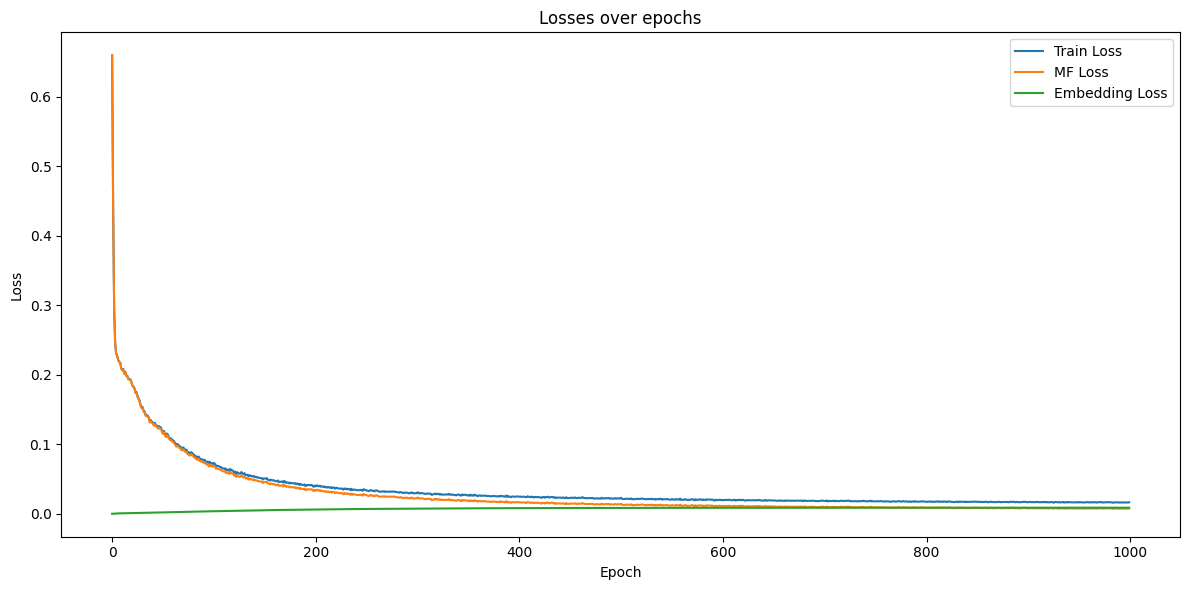

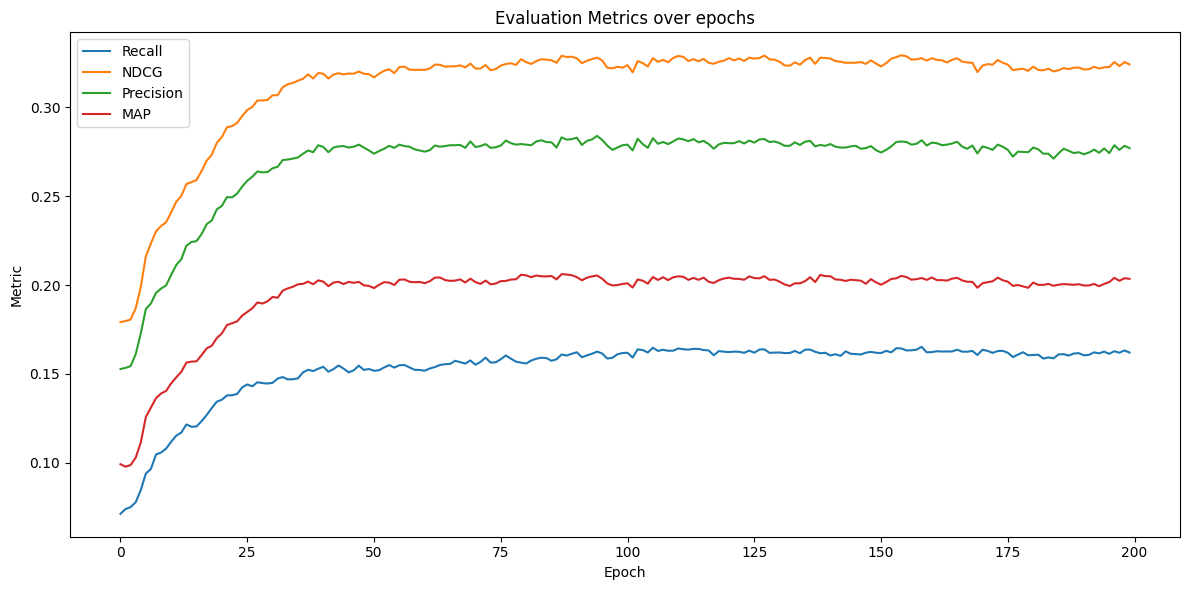

In [ ]:
import matplotlib.pyplot as plt

# plot losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(mf_losses, label='MF Loss')
plt.plot(embed_losses, label='Embedding Loss')
plt.title('Losses over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('losses_over_epochs.png')
plt.show()

# plot metrics
plt.figure(figsize=(12, 6))
plt.plot(recalls, label='Recall')
plt.plot(ndcgs, label='NDCG')
plt.plot(precisions, label='Precision')
plt.plot(maps, label='MAP')
plt.title('Evaluation Metrics over epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.tight_layout()
plt.savefig('evaluation_metrics_over_epochs.png')
plt.show()


### 2.5 Recommendation and Evaluation

Recommendation and evaluation have been performed on the specified test set during training. After training, we can also use the model to perform recommendation and evalution on other data. Here we still use `test` as test data, but `test` can be replaced by other data with similar data structure.

#### 2.5.1 Recommendation

We can call `recommend_k_items` to recommend k items for each user passed in this function. We set `remove_seen=True` to remove the items already seen by the user. The function returns a dataframe, containing each user and top k items recommended to them and the corresponding ranking scores.

In [ ]:
TOP_K=10
topk_scores = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

topk_scores.head()

,userID,itemID,prediction
0,1,593,9.765488
1,1,1387,9.508644
2,1,1923,9.385398
3,1,1287,9.346621
4,1,924,9.339483


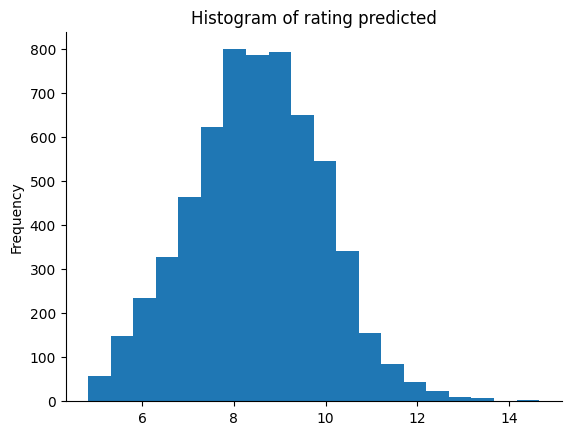

In [ ]:
# @title prediction

from matplotlib import pyplot as plt
topk_scores['prediction'].plot(kind='hist', bins=20, title='Histogram of rating predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### 2.5.2 Evaluation

With `topk_scores` predicted by the model, we can evaluate how LightGCN performs on this test set.

In [ ]:
eval_map = map_at_k(test, topk_scores, k=TOP_K)
eval_ndcg = ndcg_at_k(test, topk_scores, k=TOP_K)
eval_precision = precision_at_k(test, topk_scores, k=TOP_K)
eval_recall = recall_at_k(test, topk_scores, k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.203541
NDCG:	0.324148
Precision@K:	0.277049
Recall@K:	0.162039


In [ ]:
# Count how many times each movie is recommended
movie_recommendation_counts = topk_scores['itemID'].value_counts().reset_index()
movie_recommendation_counts.columns = ['movieId', 'recommendation_count']

# Sort the movies by the count in descending order
most_recommended_movies = movie_recommendation_counts.sort_values(by='recommendation_count', ascending=False)




In [ ]:
# Display the top recommended movies
most_recommended_movies.head()

,movieId,recommendation_count
0,356,136
1,318,130
2,593,101
3,296,94
4,2571,87


In [ ]:
movies = pd.read_csv("movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:

most_recommended_movies_with_titles = most_recommended_movies.merge(movies, on='movieId')
# The movie titles along with their recommendation counts
most_recommended_movies_with_titles

,movieId,recommendation_count,title,genres
0,356,136,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,130,"Shawshank Redemption, The (1994)",Crime|Drama
2,593,101,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
3,296,94,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,2571,87,"Matrix, The (1999)",Action|Sci-Fi|Thriller
...,...,...,...,...
992,2414,1,Young Sherlock Holmes (1985),Action|Adventure|Children|Fantasy|Mystery|Thri...
993,82459,1,True Grit (2010),Western
994,3087,1,Scrooged (1988),Comedy|Fantasy|Romance
995,2139,1,"Secret of NIMH, The (1982)",Adventure|Animation|Children|Drama


from matplotlib import pyplot as plt
most_recommended_movies_with_titles['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
most_recommended_movies_with_titles['recommendation_count'].plot(kind='hist', bins=20, title='recommendation_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
most_recommended_movies_with_titles.plot(kind='scatter', x='movieId', y='recommendation_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
most_recommended_movies_with_titles['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
most_recommended_movies_with_titles['recommendation_count'].plot(kind='line', figsize=(8, 4), title='recommendation_count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
most_recommended_movies_with_titles.to_csv('most_recommended_movies.csv')

   movieId  recommendation_count                             title  \
0      356                   136               Forrest Gump (1994)   
1      318                   130  Shawshank Redemption, The (1994)   
2      593                   101  Silence of the Lambs, The (1991)   
3      296                    94               Pulp Fiction (1994)   
4     2571                    87                Matrix, The (1999)   

                        genres  
0     Comedy|Drama|Romance|War  
1                  Crime|Drama  
2        Crime|Horror|Thriller  
3  Comedy|Crime|Drama|Thriller  
4       Action|Sci-Fi|Thriller  


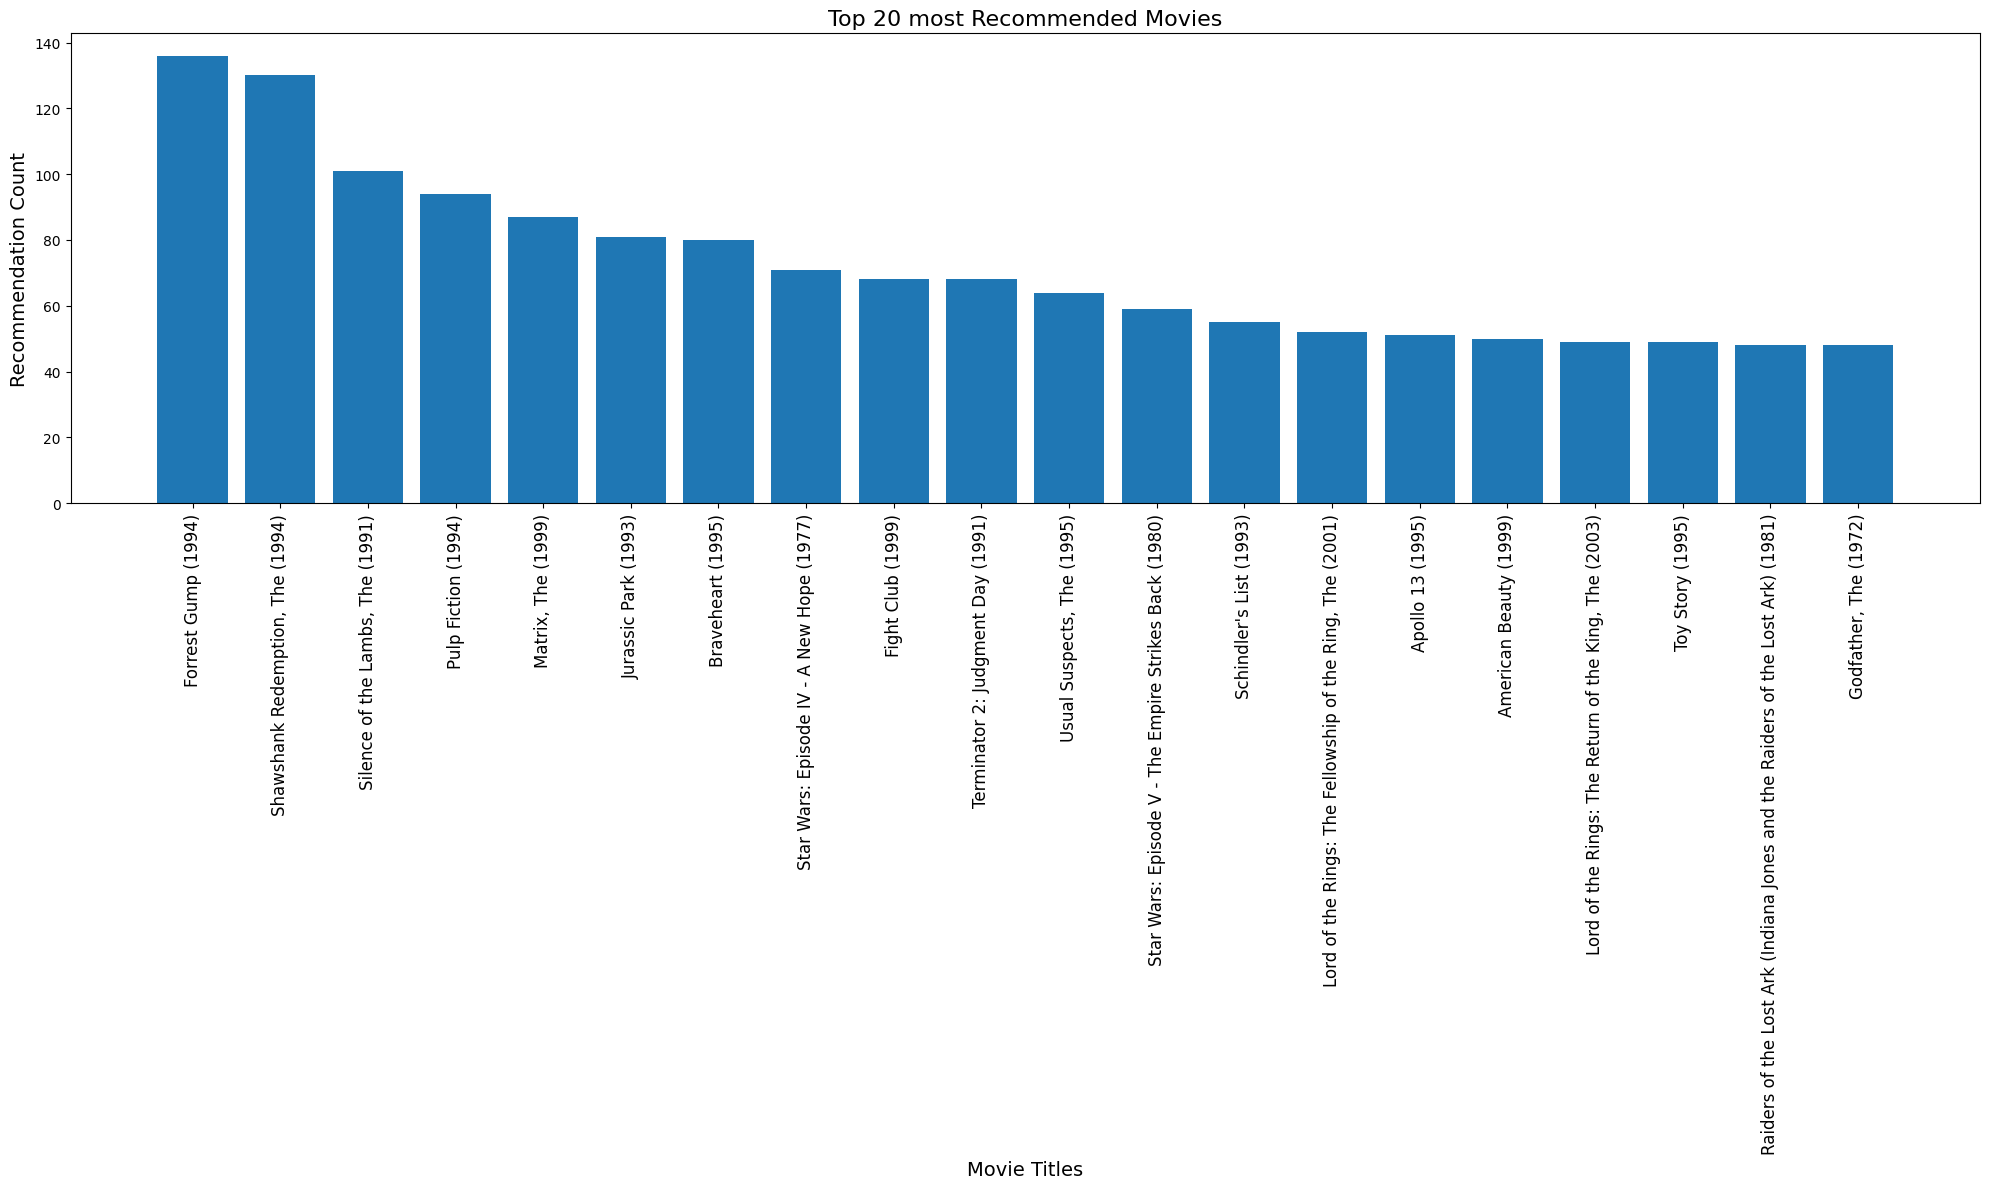

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

print(most_recommended_movies_with_titles.head())

plt.figure(figsize=(20, 12))

# Plot
plt.bar(
    x=most_recommended_movies_with_titles['title'].head(20),
    height=most_recommended_movies_with_titles['recommendation_count'].head(20)
)

plt.xticks(
    rotation=90,
    fontsize=12
)

plt.xlabel('Movie Titles', fontsize=14)
plt.ylabel('Recommendation Count', fontsize=14)
plt.title('Top 20 most Recommended Movies', fontsize=16)

plt.tight_layout()
plt.savefig('top_20_movies.png')
plt.show()


### 2.6 Infer embeddings

With `infer_embedding` method of LightGCN model, we can export the embeddings of users and items in the training set to CSV files for future use.

In [ ]:
model.infer_embedding(user_file, item_file)

### References:
1. Xiangnan He, Kuan Deng, Xiang Wang, Yan Li, Yongdong Zhang & Meng Wang, LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation, 2020, https://arxiv.org/abs/2002.02126
2. LightGCN implementation [TensorFlow]: https://github.com/kuandeng/lightgcn
3. Thomas N. Kipf and Max Welling, Semi-Supervised Classification with Graph Convolutional Networks, ICLR, 2017, https://arxiv.org/abs/1609.02907
4. Xiang Wang, Xiangnan He, Meng Wang, Fuli Feng, and Tat-Seng Chua, Neural Graph Collaborative Filtering, SIGIR, 2019, https://arxiv.org/abs/1905.08108
5. Y. Koren, R. Bell and C. Volinsky, "Matrix Factorization Techniques for Recommender Systems", in Computer, vol. 42, no. 8, pp. 30-37, Aug. 2009, doi: 10.1109/MC.2009.263.  url: https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf